In [ ]:
! pip install scikit-plot

In [ ]:
from google.colab import drive
drive.mount('content/')

Mounted at content/


In [ ]:
!unzip '/content/content/MyDrive/Expression_Dataset.zip'

# **Pre processing**

In [74]:
import os
import cv2
import math
import joblib
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
BASE_DIR = '/content/Dataset'
DATASET_PATH = BASE_DIR + '/'
EXPRESSIONS = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
TRAIN_SIZE = 0.85
input_shape = (48, 48, 1)
number_of_classes = len(EXPRESSIONS)
print(number_of_classes) 

6


In [ ]:
total_images = 0
for dir_ in os.listdir(BASE_DIR):
  if dir_ in EXPRESSIONS:
    count = 0
    for f in os.listdir(BASE_DIR + '/' + dir_ + '/'):
      count += 1
    print(f"{dir_} has {count} number of images.")
    total_images += count
print(f"Total images {total_images}")

Surprise has 249 number of images.
Sadness has 1153 number of images.
Neutral has 1230 number of images.
Fear has 728 number of images.
Angry has 938 number of images.
Happy has 2203 number of images.
Total images 6501


In [ ]:
image_array = []
image_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(BASE_DIR):
  if dir_ in EXPRESSIONS:
    for f in os.listdir(BASE_DIR + '/' + dir_ + '/'):
      image_array.append(np.expand_dims(cv2.imread(BASE_DIR + '/' + dir_ + '/' + f, 0), axis = 2))
      image_label.append(label)
    print(f"{dir_} loaded..")
    label_to_text[label] = dir_
    label += 1

image_array = np.array(image_array)
image_label = np.array(image_label)
image_label = OneHotEncoder(sparse= False).fit_transform(image_label.reshape(-1, 1))

image_array.shape, image_label.shape, label_to_text 

Surprise loaded..
Sadness loaded..
Neutral loaded..
Fear loaded..
Angry loaded..
Happy loaded..


((6501, 48, 48, 1),
 (6501, 6),
 {0: 'Surprise',
  1: 'Sadness',
  2: 'Neutral',
  3: 'Fear',
  4: 'Angry',
  5: 'Happy'})

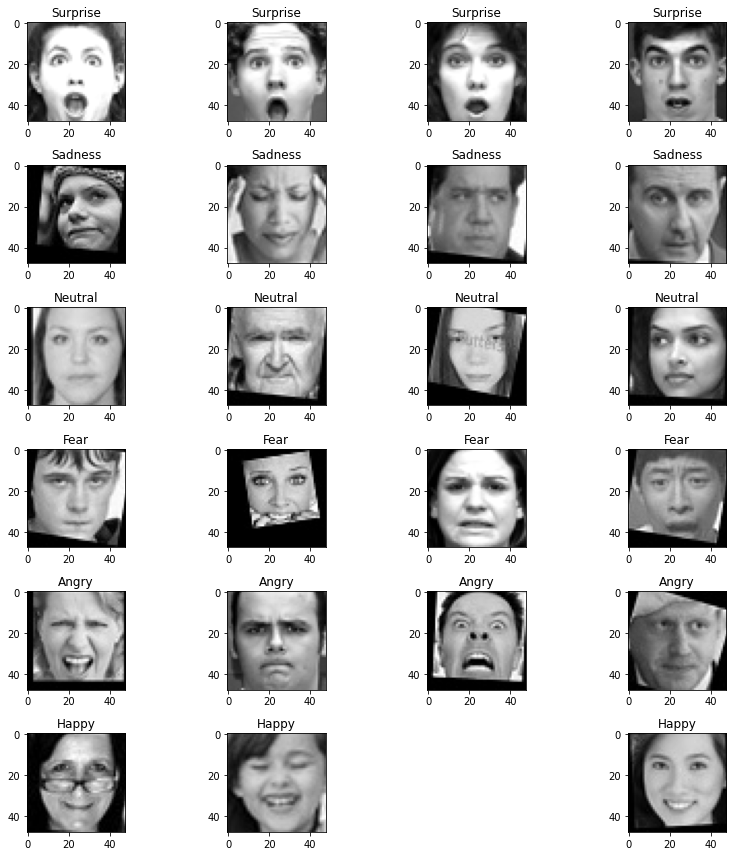

In [ ]:
figure = pyplot.figure(1, (number_of_classes*2, number_of_classes*2))
index = 0
for i in label_to_text:
  indices = np.random.choice(np.where(image_label[:, i] == 1)[0], size= 4, replace = False)
  images = image_array[indices]
  for img in images:
    index += 1
    ax = pyplot.subplot(number_of_classes, 4, index)
    ax.imshow(img.reshape(48, 48), cmap='gray')
    ax.set_title(label_to_text[i])
    pyplot.tight_layout()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_array, image_label, shuffle= True, stratify= image_label, train_size = TRAIN_SIZE, random_state = 40)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5525, 48, 48, 1), (976, 48, 48, 1), (5525, 6), (976, 6))

# **Implementing ResNet (from research paper)**

### Implementing different blocks of the model

In [83]:

def identity_block(X, kernel: tuple, filters: list, stage: int, block_id: str):
    conv_name = 'idblock_conv_' +  str(stage) + f'_{block_id}'
    bn_name = 'idblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "idblock_actv_" + str(stage) + f'_{block_id}'
    
    X_shortcut = X
    
    X = Conv2D( filters = filters[0], kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name + '_a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)

    X = Conv2D( filters = filters[1], kernel_size = kernel, strides = (1,1), padding = 'same', name = conv_name + '_b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D( filters = filters[2], kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name + '_c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)
    
    return X

In [84]:
def convolutional_block(X, kernel: tuple, stride: tuple, filters: list, stage: int, block_id: str):    
    conv_name = 'convblock_conv_' + str(stage) + f'_{block_id}'
    bn_name = 'convblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "convblock_actv_" + str(stage) + f'_{block_id}'

    X_shortcut = X

    X = Conv2D(filters[0], kernel_size = (1, 1), strides = stride, name = conv_name + '_a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)
    
    X = Conv2D(filters[1], kernel_size = kernel, strides = (1,1), padding = 'same', name = conv_name + '_b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D(filters[2], kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name + '_c', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X_shortcut = Conv2D(filters[2], kernel_size = (1,1), strides = stride, padding = 'valid', name = conv_name + '_sc1', kernel_initializer=glorot_uniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name + '_sc1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)

    return X

In [85]:
def CNN_with_SkipConnections(input_shape, classes, show_summary=False):
    model_in = Input(input_shape)

    X = Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'valid', name = 'conv_0_a', kernel_initializer = glorot_uniform(seed=0))(model_in)
    X = BatchNormalization(axis = 3, name = 'bn_0_a')(X)
    X = Activation('relu', name="actv_0_a")(X)

    X = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid', name = 'conv_0_b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_0_b')(X)
    X = Activation('relu', name="actv_0_b")(X)

    # Block 0
    X = convolutional_block(model_in, (3,3), stride=(1,1), filters = [32, 32, 64], stage=0, block_id='a')
    X = identity_block(X, (3,3), [32, 32, 64], stage=0, block_id='a')

    # Block 1
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [64, 64, 128], stage=1, block_id='a')
    X = identity_block(X, (3,3), [64, 64, 128], stage=1, block_id='a')
 
    # Block 2
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [128,128,256], stage=2, block_id='a')
    X = identity_block(X, (2,2), [128,128,256], stage=2, block_id='a')

    X = AveragePooling2D()(X)

    X = Flatten()(X)
    X = Dense(128, kernel_initializer = glorot_uniform(seed=0), name = 'dense_1',)(X)
    X = BatchNormalization(name = 'bn_3')(X)
    X = Activation('relu', name="actv_3")(X)

    model_out = Dense(classes, activation='softmax', name="out_layer")(X)
    
    model = Model(inputs = model_in, outputs = model_out, name='CNN_with_SkipConnections')

    if show_summary:
        model.summary()

    return model

In [86]:
model = CNN_with_SkipConnections(input_shape, number_of_classes, show_summary=True)

Model: "CNN_with_SkipConnections"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
convblock_conv_0_a_a (Conv2D)   (None, 48, 48, 32)   64          input_13[0][0]                   
__________________________________________________________________________________________________
convblock_bn_0_a_a (BatchNormal (None, 48, 48, 32)   128         convblock_conv_0_a_a[0][0]       
__________________________________________________________________________________________________
convblock_actv_0_a_a (Activatio (None, 48, 48, 32)   0           convblock_bn_0_a_a[0][0]         
___________________________________________________________________________

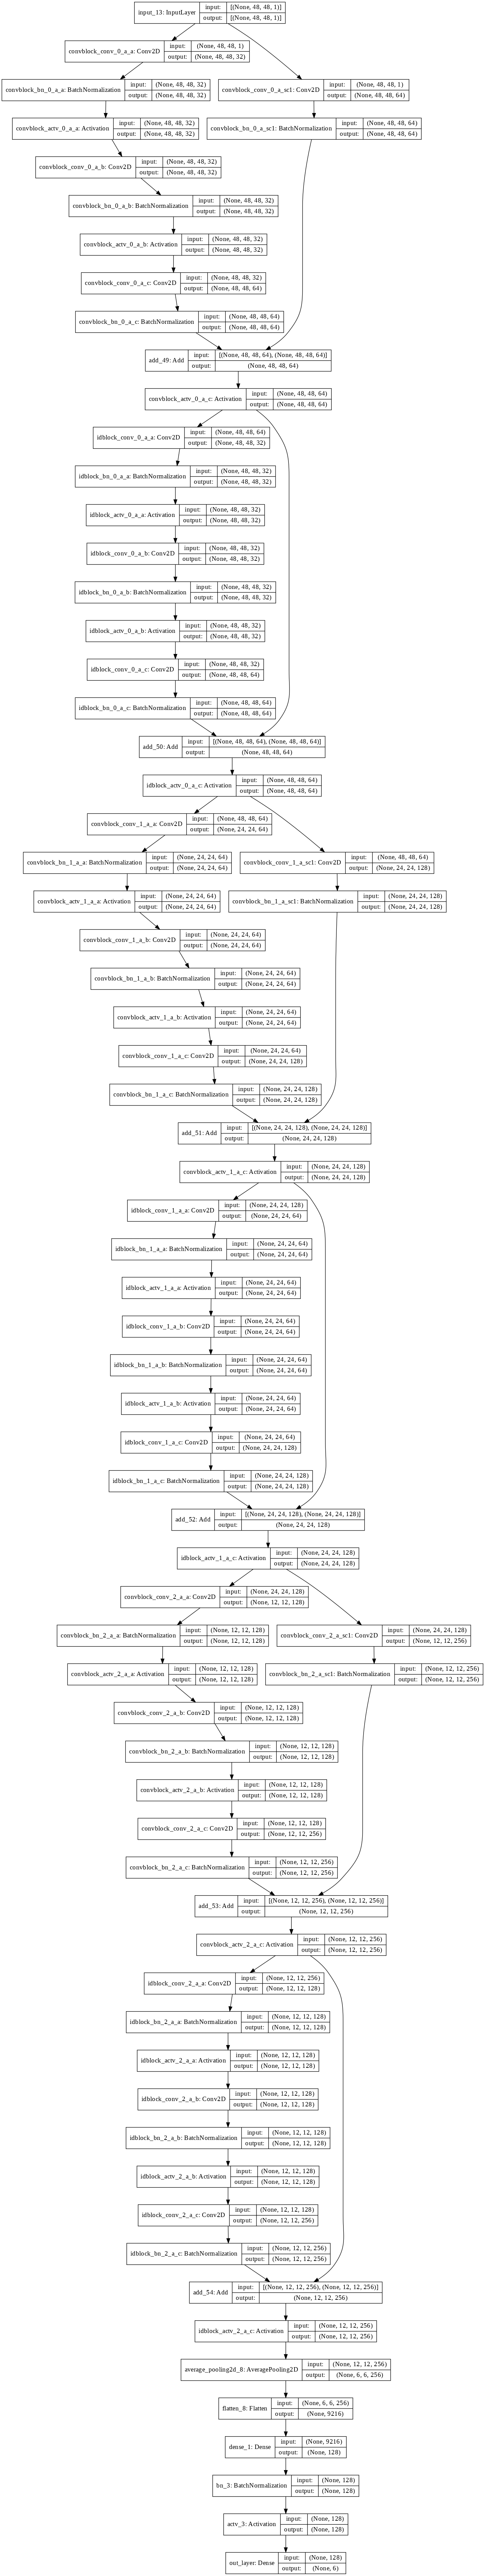

In [87]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=100,)

In [88]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=7,
    verbose=1,
    restore_best_weights=True,
)

In [89]:
batch_size = 32
epochs = 60
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.01)

In [90]:

model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy']
)

train_datagen.fit(x_train)
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data = (x_test, y_test),
    steps_per_epoch = len(x_train) / batch_size,
    epochs = epochs,
    callbacks = [lr_scheduler, early_stopping],
)

Epoch 1/60
172/172 [==============================] - 9s 40ms/step - loss: 1.7599 - accuracy: 0.3302 - val_loss: 4.8097 - val_accuracy: 0.2674
Epoch 2/60
172/172 [==============================] - 6s 37ms/step - loss: 1.4365 - accuracy: 0.4243 - val_loss: 1.3905 - val_accuracy: 0.4652
Epoch 3/60
172/172 [==============================] - 6s 37ms/step - loss: 1.2507 - accuracy: 0.5047 - val_loss: 1.2767 - val_accuracy: 0.4918
Epoch 4/60
172/172 [==============================] - 7s 38ms/step - loss: 1.1059 - accuracy: 0.5596 - val_loss: 1.1277 - val_accuracy: 0.5420
Epoch 5/60
172/172 [==============================] - 7s 38ms/step - loss: 1.0548 - accuracy: 0.5887 - val_loss: 1.7334 - val_accuracy: 0.3504
Epoch 6/60
172/172 [==============================] - 7s 38ms/step - loss: 0.9906 - accuracy: 0.6085 - val_loss: 1.3163 - val_accuracy: 0.5000
Epoch 7/60
172/172 [==============================] - 7s 38ms/step - loss: 0.9238 - accuracy: 0.6396 - val_loss: 1.0658 - val_accuracy: 0.5963

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

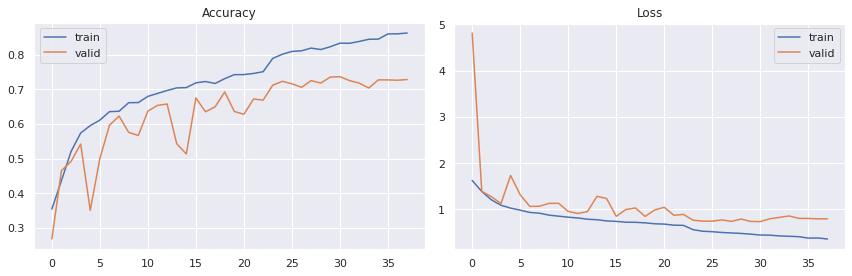

In [91]:

sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

test accuracy: 73.668 %


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.58      0.54      0.56       173
           2       0.57      0.64      0.60       185
           3       0.70      0.73      0.72       109
           4       0.73      0.70      0.72       141
           5       0.90      0.88      0.89       331

    accuracy                           0.74       976
   macro avg       0.75      0.75      0.75       976
weighted avg       0.74      0.74      0.74       976



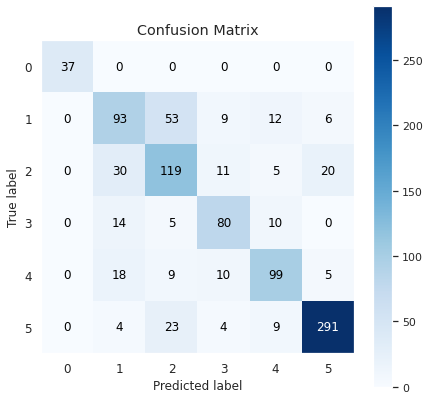

In [92]:

yhat_test = np.argmax(model.predict(x_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [93]:
yhat_train = np.argmax(model.predict(x_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

train accuracy: 88.2353 %


In [94]:
model.save('resnet_implementation_model.h5')